## The Curse of Dimensionality

High dimensional space is hard to image, as an example, let's take a look at a tesseract (4d cube aka hypercube):

https://www.youtube.com/watch?v=BVo2igbFSPE

Pretty crazy - and that is only 4 dimensions! What about the thousands of features you just threw at your gradient boosted tree? That is a lot of dimensions! And things behave differently in high dimensions.

For example, "if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1,000,000-dimensional hypercube? Well, the average distance, believe it or not, will be about 408.25." (Source: Hands on Machine Learning p.207)

Thus, in high dimensions, things become very sparse and observations have a higher chance of being far away from eachother. This also applies to our test set or future predictions and thus training points are less likely to generalize to new data points (aka overfitting). 

If you refer back to lecture 4, you will remember to combat overfitting, we can try the following:

* Get more training data
* Try a smaller set of features
* Try a less complex model
* Add regularization

And while in theory all of these work, some can be harder in practice. For example, getting enough data to fill out 1,000 dimensions is not feasible. In this lecture, we will focus on techniques that allow you to use less features without explicitly dropping any individual features. 

## Principle Component Analysis (PCA)

To start off, let's first get a visual understanding:

http://setosa.io/ev/principal-component-analysis/

So - what did we learn? PCA is a technique that projects our data onto the axes with the highest variance. The idea being that it is the least information lost. Thus, the first principal component is the axis that preserves the most variance, the second principal component is the one orthogonal to the first that preserves the next most amount of variance, the third being orthogonal to the first 2 and preserving the next most amount of variance, etc. Note: you can't have more axes then features.

How do we find these principal components? Fortunately, there is a matrix factorization techinque called SVD. Assume you have training data $X$.

SVD says $X = U\Sigma V^{T}$

If you perform this decomposition, $V^{T}$'s columns will be your principal components.

So - let's take a look at an example:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

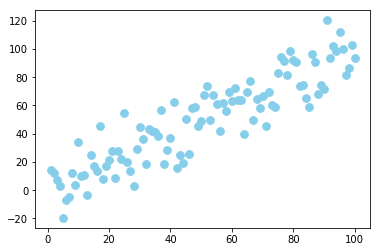

In [2]:
df= pd.DataFrame({'X': range(1,101), 
                  'Y': np.random.randn(100)*15+range(1,101)})
plt.scatter(df['X'], df['Y'], c='skyblue', s=60)

Note: PCA assumes that the data are centered around the origin, so subtract the mean from each column

In [3]:
df_scaled = df - df.mean()
U, s, V = np.linalg.svd(df_scaled.values)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
print(c1)
print(c2)

[ 0.67343708  0.73924454]
[ 0.73924454 -0.67343708]


Now that we have these principal components, we just need to project the data onto them. You do this with a simple dot product:

In [4]:
proj_1 = df_scaled.dot(c1)

Here we have projected our data onto the first principal component, let's take a look:

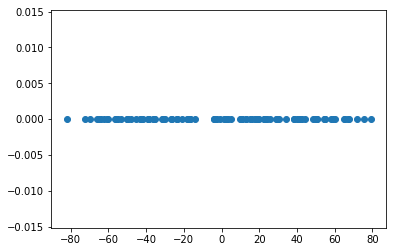

In [5]:
plt.scatter(proj_1, np.zeros(len(proj_1)))

And here is for projecting just on the 2nd component:

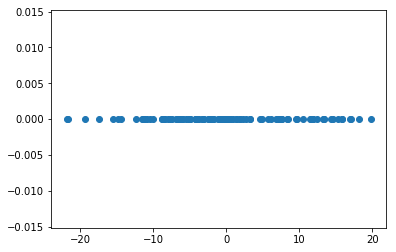

In [6]:
proj_2 = df_scaled.dot(c2)
plt.scatter(proj_2, np.zeros(len(proj_2)))

You can see that the first has more variance than the first. Here is projecting onto the first two together and then inverting the process to show that in fact in reproduces our data. Cool! It exactly reproduces our data because we originally had 2 features and used both principal components.

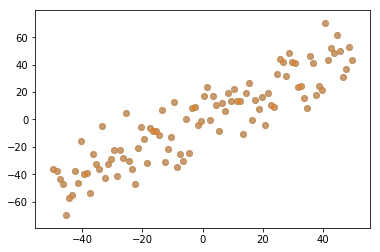

In [7]:
proj_1_2 = df_scaled.dot(V.T)
reconstruct = proj_1_2.dot(V)
plt.scatter(reconstruct.values[:,0], reconstruct.values[:,1], alpha=0.5)
plt.scatter(df_scaled['X'], df_scaled['Y'], alpha=0.5)

We can also check that our principle components are indeed orthogonal. And visually seems to be in high variance directions.

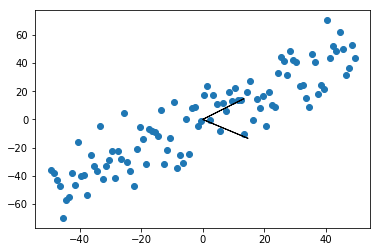

In [8]:
plt.scatter(df_scaled.values[:,0], df_scaled.values[:,1])
plt.arrow(x=0,y=0,dx=c1[0]*20,dy=c1[1]*20)
plt.arrow(x=0,y=0,dx=c2[0]*20,dy=c2[1]*20)

Let's take a look at sklearn (automatically subtracts the mean) and a larger dataset. We create a dataset of 100 features and 1000 samples. Let's first use PCA with 2 components.

In [9]:
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA

In [10]:
X, y = make_regression(n_features=100, n_samples=1000, effective_rank=20)
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X)

Pretty easy - and how we have a dataset with a much lower dimension:

In [11]:
X_2dim.shape

(1000, 2)

But, how do we choose the number of components to use? A very common method is the **explained variance ratio.** This ratio is the fraction of the dataset's variance that lies along each principal component. They are easy to access in sklearn:

In [12]:
pca.explained_variance_ratio_

array([ 0.03593563,  0.03575261])

So - 3.6% of the variance lies along the first principal component and 3.5% along the 2nd, so in using both we explained about 7.1% of the variance - not a lot. Let's graph this ratio cumulatively for all of our components:

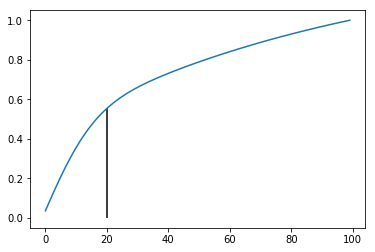

In [13]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[20],x=20)

We can see from above how our explained ratio increases to 100 percent as we continue to add principal components. We also see an elbow in our graph at 20 components. Thus, one option would be to use 20 components when reducing the dimensionality since the rate of reduction in variance decreases after that. Another option would be to use the number of components necessary to reach a certain amount of explained variance. For example, we could calculate how many components we would need to explain at least 95% of the variance:

In [14]:
index_95 = np.argmax(cum_ratio >= 0.95)
print(index_95)
print(cum_ratio[index_95])

86
0.953777093382


Thus - we would need 87 components (86 + 1 since start from 0) to explain 95.38% of the variance in our data. Sklearn can also take this 0.95 fraction as n_components and will automatically use the number of components necessary to reach that amount of explained variance:

In [15]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(1000, 87)


PCA can also be used for compression, since you can reverse the transformation - see p.216 of hands on machine learning for an example. There are also a few other flavors of PCA:

* Incremental PCA - Calculates PCA using mini-batches and is useful for large data and online data
* Randomized PCA - A stocastic PCA solver that can be much faster when the number of components is much smaller than the size of the data
* Kernel PCA - can use kernels similar to SVM and can be effective at preserving clusters after projection

## T-SNE

t-SNE has become pretty popular. It is a dimensionality reduction technique, but it is mostly used for visualization and not data pre-processing. For this reason, you almost always reduce the dimensionality down to 2 with t-SNE, so that you can then plot the data in two dimensions.

The reason this is is because t-SNE's goal is to take your high dimensional data and represent it correctly in lower dimensions - thus points that are close in high dimensions should remain close in low dimensions. It does this in a non-linear and local way, so different regions of data could be transformed differently. 

t-SNE has a hyper-parameter called **perplexity**. A few notes on this parameter:
* Balances attention between local and global aspects of your data
* Guess about the number of close neighbors each point has
* Recommended to be between 5 and 50
* May require trying various values
* Should be smaller than number of points 

You also have to tune appropriate values for your learning rate and number of steps. The key is to make sure the algorithm runs long enough to stabilize.

There is an incredibly good [article on t-SNE](https://distill.pub/2016/misread-tsne/) here, so let's continue our learning here. Most of the above comes from this article and here are a few additional keys take aways:

* You cannot see relative sizes of clusters in a t-SNE plot
* Distances between well-separated clusters in a t-SNE plot may mean nothing
* Clumps of points - especially with small perplexity values - might just be noise

## SKlearn Example

As an example, let's look at the MNIST data - idea from [here](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b).

MNSIT is a dataset of hand written numbers; let's take a look:

In [16]:
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
%matplotlib inline


mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

In [17]:
print(X.shape)

(70000, 784)


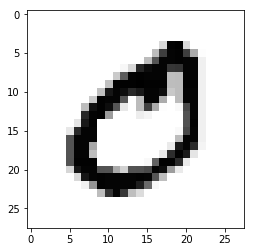

In [18]:
plt.imshow(X[1].reshape((28,28)), cmap='Greys')

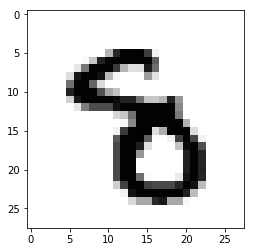

In [19]:
plt.imshow(X[50000].reshape((28,28)), cmap='Greys')

As you can see we have 70000 images which are 28x28, but when flattened into a vector become 784 values. These are our features. It is hard to visualize 784 features, but let's see if we can use t-SNE to reduce the dimensionality down to 2 and visualize our numbers

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

#first reduce dimensionality before feeding to t-sne
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

rows_selected = np.random.shuffle(np.arange(70000))
print(rows_selected)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows,:])

None


ValueError: Found array with dim 3. Estimator expected <= 2.

## Other Techniques of Interest

* Locally Linear Embedding (LLE) - this is a nonlinear dimensionality technique that is good at unrolling manifolds. 
* Linear Discriminant Analysis (LDA) - this is a good technique to use to reduce dimensionality when you have class labels on your data as it finds the projection that maximizes the class distances.